In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

SHOW_DEBUG_STEP=False

In [ ]:
import os
os.chdir("/content/drive/MyDrive/CNN /X-ray")

# Data Loading and Preparation

In [ ]:
data_path="./data"
disease_cls=['effusion','nofinding']


In [ ]:
effusion_path=os.path.join(data_path,disease_cls[0],"*")
nofinding_path=os.path.join(data_path,disease_cls[1],"*")
effusion_img=glob.glob(effusion_path)
nofinding_img=glob.glob(nofinding_path)

if SHOW_DEBUG_STEP:
    if len(effusion_img) or len(nofinding_path)>0:
        print("img_with_effusion: {},img_with_nofinding: {}".format(len(effusion_img),len(nofinding_img)))
    else:
        print(" Data not loaded check again") 

In [ ]:
# method to plot images with user deifned caption 

def plot_img(images,captions=None,cmap='gray'):
    f,axes=plt.subplots(1,len(images),sharey=True)
    f.set_figwidth(15,15)
    for ax,image,caption in zip(axes,images,captions):
        ax.imshow(image,cmap)
        ax.set_title(caption)

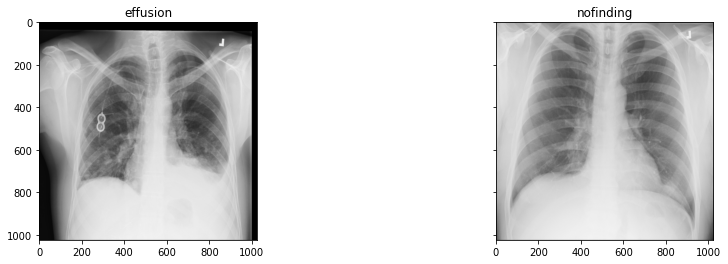

In [ ]:
# reading 
rand_x=random.randint(0,min(len(effusion_img),len(nofinding_img)))
nofind_img_1=cv2.imread(nofinding_img[rand_x])
effusion_img_1=cv2.imread(effusion_img[rand_x])
plot_img([effusion_img_1,nofind_img_1],captions=['effusion','nofinding'],cmap='gray')
if SHOW_DEBUG_STEP:
    print("Shape of image with no finding",str(nofind_img_1.shape))
    print("Shape of image with effusion",str(effusion_img_1.shape))

# Data  augmentation and Model Building

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import rescale
import resnet

In [ ]:
n_channels=1
img_width=256
img_height=256
nb_classes=2

In [ ]:
# /content/drive/MyDrive/kaggle

In [ ]:
#Data genrstor
datagen= ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False
)

def preprocess_img(img, mode):
    #normalization
    img=(img-img.min())/(img.max()-img.min())
    img=rescale(img,0.25,multichannel=True,mode='constant')

    if mode=='train':
        if np.random.randn()>0:
            img = datagen.random_transform(img)
    return img
        

In [ ]:
import numpy as np
import tensorflow as tf
from skimage import io

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(data_path, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
# class AugmentedDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self,mode='train',ablation=None,disease_cls=['nofinding','effusion'],
#                  batch_size=32,dim=(256,256),n_channels=1,shuffle=True):
#         self.dim=dim
#         self.batch_size=batch_size
#         self.labels={}
#         self.list_IDs=[]
#         self.mode=mode

#         for i,cls in enumerate(disease_cls):
#             paths=os.path.join(data_path,cls,'*')
#             brk_point=int(len(paths)*0.8)
#             if self.mode=='train':
#                 paths=paths[:brk_point]
#             else:
#                 paths=paths[brk_point:]
            
#             if ablation is not None:
#                 paths=paths[:int(len(paths)*ablation/100)]
#             self.list_IDs+=paths
#             self.labels.update({p:i for p in paths})

#         self.n_channels=n_channels
#         self.n_classes=len(disease_cls)
#         self.shuffle=shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         return int(np.floor(len(self.list_IDs) / self.batch_size))
#     def __getitem__(self,index):

#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         list_IDs_temp=[self.list_IDs[k] for k in indexes]

#         X,y=self.__data_generation(list_IDs_temp)

#         return X,y


#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         X=np.empty((self.batch_size,*self.dim,self.n_channels))

#         y=np.empty(self.batch_size,dtype=int)

#         delete_rows=[]

#         for i,ID in enumerate (list_IDs_temp):
#             img=cv2.imread(ID)
#             img=img[:,:,np.newaxis]

#             if img.shape ==(1024,1024,1):
#                 X[i,]=img
#                 y[i]=self.labels[ID]
#             else:
#                 delete_row.append(i)
#                 continue
        
#         X=np.delete(X,delete_rows,axis=0)
#         y=np.delete(y,delete_rows,axis=0)
    
#         return X,tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
# initialising model
model=resnet.ResnetBuilder.build_resnet_18((n_channels,img_width,img_height),nb_classes)

model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator=AugmentedDataGenerator('train',ablation=10)
validation_generator=AugmentedDataGenerator('val',ablation=10)

model.fit(training_generator,epochs=1,validation_data=validation_generator)

2/2 [==============================] - 8s 129ms/step - loss: 1.5781 - accuracy: 0.6667


In [ ]:
model=resnet.ResnetBuilder.build_resnet_18((n_channels,img_width,img_height),nb_classes)

model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator=AugmentedDataGenerator('train',ablation=10)
validation_generator=AugmentedDataGenerator('val',ablation=10)

model.fit(training_generator,epochs=5,validation_data=validation_generator)

Epoch 1/5
2/2 [==============================] - 7s 3s/step - loss: 1.8530 - accuracy: 0.3171
Epoch 2/5
2/2 [==============================] - 5s 2s/step - loss: 1.4215 - accuracy: 0.9152
Epoch 3/5
2/2 [==============================] - 5s 2s/step - loss: 1.3344 - accuracy: 0.9062
Epoch 4/5
2/2 [==============================] - 5s 2s/step - loss: 1.2394 - accuracy: 0.9473
Epoch 5/5
2/2 [==============================] - 5s 2s/step - loss: 1.2697 - accuracy: 0.9148


In [ ]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch {}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((n_channels, img_width, img_height), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - 18s 3s/step - loss: 1.3465 - accuracy: 0.9233 - val_loss: 2.6304 - val_accuracy: 0.9355

Val AUC for epoch 0: 0.5892857142857143
Epoch 2/5
5/5 [==============================] - 14s 3s/step - loss: 1.2889 - accuracy: 0.9001 - val_loss: 2.2256 - val_accuracy: 0.9333

Val AUC for epoch 1: 0.6810344827586208
Epoch 3/5
5/5 [==============================] - 13s 3s/step - loss: 1.3331 - accuracy: 0.8786 - val_loss: 1.9749 - val_accuracy: 0.9355

Val AUC for epoch 2: 0.6458333333333334
Epoch 4/5
5/5 [==============================] - 13s 3s/step - loss: 1.2411 - accuracy: 0.9156 - val_loss: 2.2566 - val_accuracy: 0.9032

Val AUC for epoch 3: 0.7974137931034483
Epoch 5/5
5/5 [==============================] - 13s 3s/step - loss: 1.2992 - accuracy: 0.8930 - val_loss: 1.5812 - val_accuracy: 0.9355

Val AUC for epoch 4: 0.6049382716049383


#### We are getting high accuracy but low auc score

Now we will use weighted cross entropy 
becoz we have imbalance data and we don't want model to predict everyone as "nofinding"

In [ ]:
from functools import partial
import tensorflow.keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((n_channels, img_width, img_height), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=None)

1/1 [==============================] - 4s 4s/step - loss: 8.8341 - accuracy: 0.0968


### Final Run
<br>
After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [ ]:
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((n_channels, img_width, img_height), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train')
validation_generator = AugmentedDataGenerator('val')

auc_logger = roc_callback()
filepath = './models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

model.fit(training_generator, epochs=50, validation_data=validation_generator, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/50
27/27 [==============================] - 76s 3s/step - loss: 2.3379 - accuracy: 0.4352 - val_loss: 3.2593 - val_accuracy: 0.1038

Val AUC for epoch 0: 0.5488621151271753

Epoch 00001: val_accuracy improved from -inf to 0.10383, saving model to ./models/best_model.hdf5
Epoch 2/50
27/27 [==============================] - 71s 3s/step - loss: 2.1607 - accuracy: 0.6520 - val_loss: 4.4388 - val_accuracy: 0.0978

Val AUC for epoch 1: 0.4056437389770723

Epoch 00002: val_accuracy did not improve from 0.10383
Epoch 3/50
27/27 [==============================] - 72s 3s/step - loss: 2.1214 - accuracy: 0.5528 - val_loss: 3.0652 - val_accuracy: 0.1148

Val AUC for epoch 2: 0.46872920825016634

Epoch 00003: val_accuracy improved from 0.10383 to 0.11475, saving model to ./models/best_model.hdf5
Epoch 4/50
27/27 [==============================] - 72s 3s/step - loss: 2.0272 - accuracy: 0.7772 - val_loss: 3.1913 - val_accuracy: 0.0973

Val AUC for epoch 3: 0.5158536585365854

Epoch 00004: val_

In [ ]:
val_model = resnet.ResnetBuilder.build_resnet_18((n_channels, img_width, img_height), nb_classes)
val_model.load_weights('./models/best_model.hdf5')

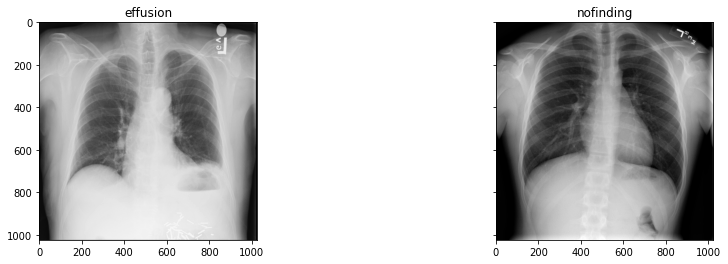

In [ ]:
effusion_path = os.path.join(data_path, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-50])

nofinding_path = os.path.join(data_path, disease_cls[1], '*')
nofinding = glob.glob(nofinding_path)
nofinding = io.imread(nofinding[-50])

plt_image

In [ ]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

array([[0.4012254, 0.5987746]], dtype=float32)

In [ ]:
#  usiing image from no finding
